<a href="https://colab.research.google.com/github/chandrusuresh/ReinforcementLearning/blob/master/Ch6-TD_Learning/Ch6_OffPolicyTDLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

## Cliff Walking
This is an example of the markov random process Example 6.6 in page-132 from the book ["Reinforcement Learning" by Barto, Sutton](http://incompleteideas.net/sutton/book/the-book.html).



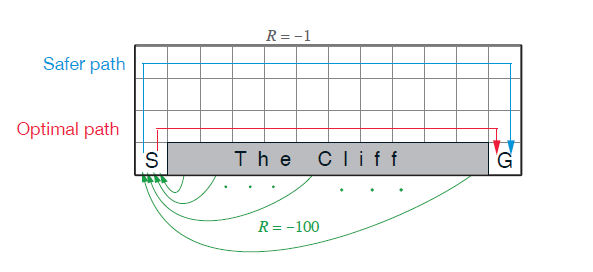

In [2]:
grid_rows = 4
grid_cols = 12
hv_actions = [[-1,0],[0,1],[1,0],[0,-1]]
start = [3,0]
goal = [3,11]

In [3]:
def getReward(pos):
  if pos[0] == 3 and pos[1] in range(1,11):
    return -100
  return -1

def getPossibleActions(actions,pos):
  new_pos = [[pos[0]+a[0],pos[1]+a[1]] for a in actions]
  act_idx = [i for i in range(len(actions)) if new_pos[i][0] in range(grid_rows) and new_pos[i][1] in range(grid_cols)]
  return np.array(act_idx)

def target_policy(Q,actions,pos,epsilon):
  idx = getPossibleActions(actions,pos)
  if epsilon > 0:
    useRandom = np.random.choice([True,False],p=[epsilon,1-epsilon])
    if useRandom:
      return np.random.choice(idx)
  maxQ = np.max(Q[pos[0],pos[1],idx])
  best_actions = idx[np.where(Q[pos[0],pos[1],idx] == maxQ)[0]]
  choice = np.random.choice(best_actions)
  return choice

def init_Q(actions):
  Q = np.zeros((grid_rows,grid_cols,len(actions)))
  for i in [0,grid_rows-1]:
    for j in range(grid_cols):
      for ia,a in enumerate(actions):
        if i+a[0] not in range(grid_rows) or j+a[1] not in range(grid_cols):
          Q[i,j,ia] = -np.inf
  for j in [0,grid_cols-1]:
    for i in range(grid_rows):
      for ia,a in enumerate(actions):
        if i+a[0] not in range(grid_rows) or j+a[1] not in range(grid_cols):
          Q[i,j,ia] = -np.inf
  return Q

def SARSA(num_episodes,actions,alpha,epsilon,gamma):
  Q = init_Q(actions)

  stats = []
  for episode in range(num_episodes):#tqdm(range(num_episodes)):
    pos = start
    steps = 0
    init = True
    traj = []
    reward = []
    while pos[0] != goal[0] or pos[1] != goal[1]:
      steps += 1
      act_idx = target_policy(Q,actions,pos,epsilon)
      a = actions[act_idx]
      next_pos = [pos[0]+a[0],pos[1]+a[1]]
      reward += [getReward(next_pos)]
      traj += [pos + [act_idx]]
      if init:
        pos = next_pos
        init = False
        continue
      prev_pos = traj[-2]
      Q[prev_pos[0],prev_pos[1],prev_pos[2]] += alpha*(reward[-2] + gamma*Q[pos[0],pos[1],act_idx] - Q[prev_pos[0],prev_pos[1],prev_pos[2]])
      if reward[-1] == -100:
        pos = start
      else:
        pos = next_pos
    stats += [[episode+1,-steps]]
  return Q,np.array(stats)

def QLearning(num_episodes,actions,alpha,epsilon,gamma):
  Q = init_Q(actions)

  stats = []
  for episode in range(num_episodes):#tqdm(range(num_episodes)):
    pos = start
    steps = 0
    init = True
    traj = []
    reward = []
    while pos[0] != goal[0] or pos[1] != goal[1]:
      steps += 1
      act_idx = target_policy(Q,actions,pos,epsilon)
      a = actions[act_idx]
      next_pos = [pos[0]+a[0],pos[1]+a[1]]
      reward += [getReward(next_pos)]
      traj += [pos + [act_idx]]
      Q[pos[0],pos[1],act_idx] += alpha*(reward[-1] + gamma*np.max(Q[next_pos[0],next_pos[1],:]) - Q[pos[0],pos[1],act_idx])
      if reward[-1] == -100:
        pos = start
      else:
        pos = next_pos
    stats += [[episode+1,-steps]]
  return Q,np.array(stats)

    

In [4]:
num_runs = 1
num_episodes = 500
epsilon = 0.1
alpha = 0.5
gamma = 1
sarsa_stats = np.zeros((num_episodes,2))
ql_stats = np.zeros((num_episodes,2))
for i in tqdm(range(num_runs)):
  Q_sarsa,stats_sarsa = SARSA(num_episodes,hv_actions,alpha,epsilon,gamma)
  Q_ql,stats_ql = QLearning(num_episodes,hv_actions,alpha,epsilon,gamma)
  
  sarsa_stats[:,1] += stats_sarsa[:,1]
  ql_stats[:,1] += stats_ql[:,1]

sarsa_stats[:,0] = stats_sarsa[:,0]
ql_stats[:,0] = stats_ql[:,0]
sarsa_stats[:,1] = sarsa_stats[:,1]/float(num_runs)
ql_stats[:,1] = ql_stats[:,1]/float(num_runs)


100%|██████████| 1/1 [00:01<00:00,  1.36s/it]


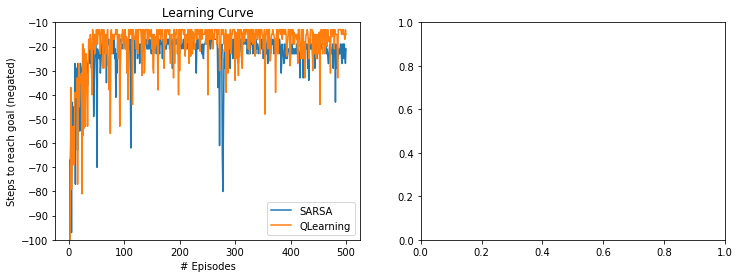

In [5]:
fig,ax = plt.subplots(1,2,figsize=(12,4))
ax[0].plot(sarsa_stats[:,0],sarsa_stats[:,1])
ax[0].plot(ql_stats[:,0],ql_stats[:,1])
ax[0].set_ylim([-100,-10])
ax[0].set_xlabel('# Episodes');
ax[0].set_ylabel('Steps to reach goal (negated)');
ax[0].set_title('Learning Curve');
ax[0].legend(['SARSA','QLearning']);